In [18]:
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import seaborn as sns
import datetime
import warnings

In [2]:
# Load data from raw_data
data = np.load('../raw_data/X_train_copernicus.npz', allow_pickle=True)

In [3]:
# Extract features from data
GHI = data['GHI']
CLS = data['CLS']
SAA = data['SAA']
SZA = data['SZA']
DATE = data['datetime']

In [4]:
def n_obs_in_day(observation = 96):
    DATE[observation]
    number_obs_day = 0 
    for i in range(8):
        if DATE[observation+i].day == DATE[observation].day:
            number_obs_day += 1
    return number_obs_day
    
n_obs_in_day()
   

4

In [5]:
# defining time variable 
def arr_time(observation= 96):
    arr_time_day = []
    
    time = datetime.datetime(year=DATE[observation].year,\
                                    month=DATE[observation].month,
                                    day=DATE[observation].day,
                                    hour=DATE[observation].hour,
                                    minute=DATE[observation].minute)
    delta = datetime.timedelta(minutes=15)
    time = time - datetime.timedelta(minutes=60)
    # we're setting the num of obs in day\n",
    observation_max = n_obs_in_day(observation)
    for j in range(observation_max):
        for i in range(8):
            time = time+delta
            arr_time_day.append(time)
    
    arr_time_day  = np.array(arr_time_day)
    return arr_time_day

In [6]:
arr_time().shape

(32,)

In [7]:
# defining solar elevation as per Federico definition 
def arr_sol_elevation(
    feature = SAA, # 
    observation = 96): 
    arr_sol_elev_day = []
    
    # we're setting the num of obs in day\n",
    observation_max = n_obs_in_day(observation)
    
    for j in range(observation_max):
        for i in range(8):
            arr_sol_elev_day.append(90-(round((feature[observation+j,i,:,:]).mean(),2)))   
    arr_sol_elev_day = np.array(arr_sol_elev_day)
    return arr_sol_elev_day 

In [8]:
def arr_feature(
    feature = CLS,
    observation = 96): 
    arr_day = []
    
    # we're setting the num of obs in day\n",
    observation_max = n_obs_in_day(observation)
    
    for j in range(observation_max):
        for i in range(8):
            arr_day.append(round((feature[observation+j,i,:,:]).mean(),2))
    arr_day = np.array(arr_day)
    return arr_day

    

In [9]:
# defining arrays 
arr_CLS = arr_feature(feature = CLS, observation = 96)
arr_SAA = arr_feature(feature = SAA, observation = 96)
arr_SZA = arr_feature(feature = SZA, observation = 96)
# setting Solar Angle Elevation as SAE
arr_SAE = arr_sol_elevation(feature = SAA, observation = 96)
arr_time_obs = arr_time(observation= 96)

## Polynomial Regression

### Plotting features

#### The Solar angles features represent the position of the sun
#### The Solar Zenith angle measures the angle between the line of sight and the vertical line
#### Note: imagine the line of sight as the imaginary line when we look at the sun
#### The Solar Azimuth angle represent the movement of the sun on the horizon
### The Solar Altitude Angle represents the height of the sun

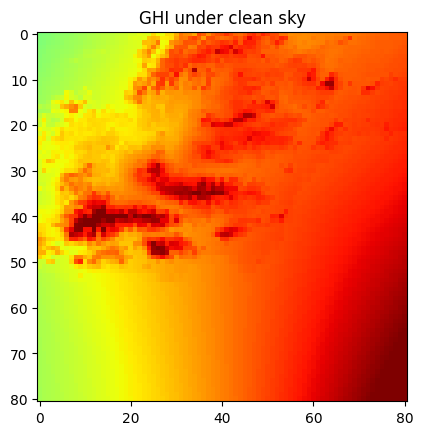

In [10]:
# Displaying one observation
plt.title("GHI under clean sky")
plt.imshow(
    CLS[96, 0,:,:], cmap='jet', norm='linear', vmin=30, vmax=120)

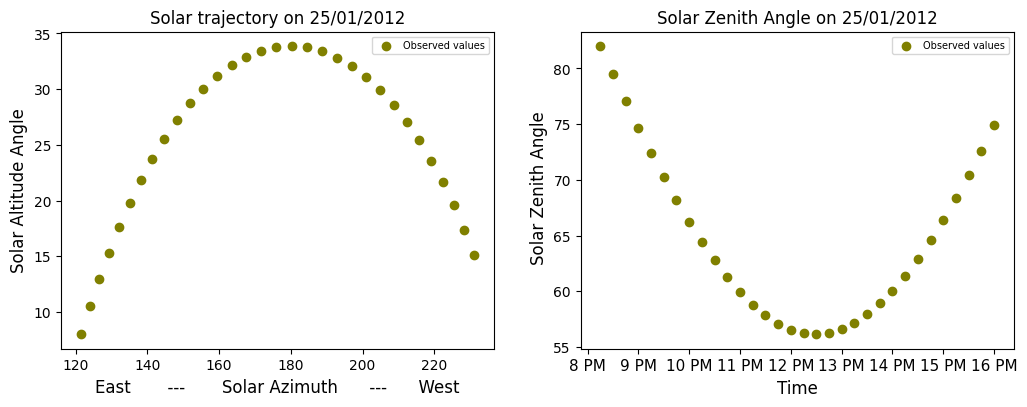

In [24]:
# to avoid a warning message 
warnings.filterwarnings("ignore")
# CHANGE THE FOLLOWING CODE
plt.figure(figsize=(19,14))

gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, -2])

# 1st subplot
ax1.scatter(arr_SZA,arr_SAE, color='olive', label='Observed values')
ax1.set_title("Solar trajectory on 25/01/2012",fontsize=12)
ax1.set_xlabel("East       ---       Solar Azimuth      ---      West", fontsize = 12)
ax1.set_ylabel("Solar Altitude Angle", fontsize = 12)
ax1.legend(loc='upper right',fontsize=7)

# 2nd subplot
ax2.scatter(arr_time_obs, arr_SAA, color='olive',label = 'Observed values')
ax2.set_title("Solar Zenith Angle on 25/01/2012",fontsize=12)
ax2.set_xlabel("Time", fontsize = 12)
ax2.set_ylabel("        Solar Zenith Angle       ",fontsize=12)
ax2.set_xticklabels(['8 PM', '9 PM', '10 PM', '11 PM', '12 PM', '13 PM', '14 PM', '15 PM', '16 PM'])
ax2.tick_params(axis='x', which='major', labelsize=11)
ax2.legend(loc='upper right',fontsize=7);

### SAA and CLS

In [26]:
# set as x variable - predictor
SAA_vect = arr_SAA.reshape((-1, 1))
SZA_vect = arr_SZA.reshape((-1, 1))
# set as y variable - response 
# y = arr_CLS

In [27]:
# x - SAA
# y - CLS
# modifying array
# modifying array
model_init = PolynomialFeatures(degree=2, include_bias=False)
feature_transformed = model_init.fit_transform(SAA_vect)
model = sm.OLS(arr_CLS, feature_transformed).fit()
CLS_pred = model.predict(feature_transformed) 
#ypred.shape


In [28]:
[model.summary()]

[<class 'statsmodels.iolib.summary.Summary'>
 """
                                  OLS Regression Results                                
 Dep. Variable:                      y   R-squared (uncentered):                   0.998
 Model:                            OLS   Adj. R-squared (uncentered):              0.998
 Method:                 Least Squares   F-statistic:                              7721.
 Date:                Tue, 06 Dec 2022   Prob (F-statistic):                    2.06e-41
 Time:                        15:43:53   Log-Likelihood:                         -140.97
 No. Observations:                  32   AIC:                                      285.9
 Df Residuals:                      30   BIC:                                      288.9
 Df Model:                           2                                                  
 Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|     

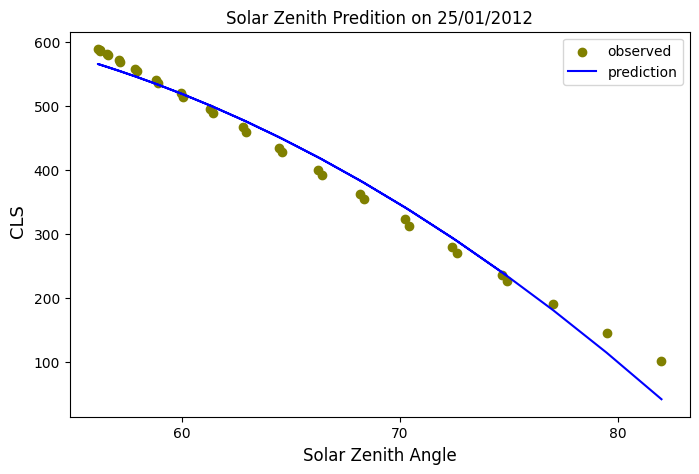

In [32]:
plt.figure(figsize=(8,5))
plt.title("Solar Zenith Predition on 25/01/2012", 
          fontsize=12)
plt.xlabel("Solar Zenith Angle",
           fontsize=12)
plt.ylabel("        CLS       ", 
           fontsize=13)
#plt.grid()
plt.xticks([30,40,50, 60, 70, 80, 90,])
plt.scatter(SAA_vect,arr_CLS, color='olive', label ='observed')
plt.plot(SAA_vect,CLS_pred, color='blue', label ='prediction');
plt.legend(loc="upper right")

#### We've an inverse relationship between these two features 
#### When we wake up and look at sun, this imaginary line of sight will be close to the horizon 
#### Then the angle between the horizon and the vertical line will be near to 90 degrees
#### And at this time solar intensity so the CLS feature will assume a lower value

#### Note: I can explain the graph by saying: start at ~(80,100) and at midday we're at ~(55,600) then we come back towards ~(80,100). the scatterplot shows two dots. One refers to the morning the other to the afternoon. 


### SZA and CLS

In [33]:
model_init2 = PolynomialFeatures(degree=4, include_bias=False)
feature_transformed2 = model_init2.fit_transform(SZA_vect)
model2 = sm.OLS(arr_CLS, feature_transformed2).fit()
CLS_pred2 = model2.predict(feature_transformed2) 

In [34]:
[model2.summary()]

[<class 'statsmodels.iolib.summary.Summary'>
 """
                                  OLS Regression Results                                
 Dep. Variable:                      y   R-squared (uncentered):                   0.999
 Model:                            OLS   Adj. R-squared (uncentered):              0.999
 Method:                 Least Squares   F-statistic:                          1.235e+04
 Date:                Tue, 06 Dec 2022   Prob (F-statistic):                    5.27e-45
 Time:                        15:44:28   Log-Likelihood:                         -121.28
 No. Observations:                  32   AIC:                                      250.6
 Df Residuals:                      28   BIC:                                      256.4
 Df Model:                           4                                                  
 Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|     

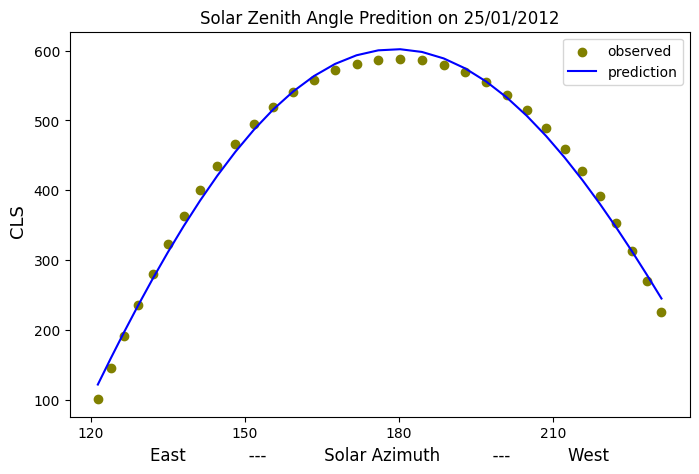

In [36]:
plt.figure(figsize=(8,5))
plt.title("Solar Zenith Angle Predition on 25/01/2012", 
          fontsize=12)
plt.xlabel("East            ---           Solar Azimuth          ---           West",
           fontsize=12)
plt.ylabel("        CLS       ", 
           fontsize=13)
#plt.grid()
plt.xticks([60,90,120, 150, 180, 210, 240, 270])
plt.scatter(SZA_vect,arr_CLS, color='olive', label ='observed')
plt.plot(SZA_vect,CLS_pred2, color='blue', label ='prediction');
plt.legend(loc="upper right")

#### Here we can see that higher the angle, the higher will be the solar intensity

### Heatmap

<AxesSubplot: >

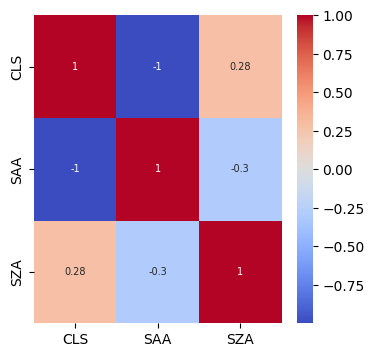

In [ ]:
features_df = pd.DataFrame({'CLS': arr_CLS, 'SAA': arr_SAA, 'SZA': arr_SZA})
plt.figure(figsize = (4,4))
sns.heatmap(features_df.corr(),cmap = 'coolwarm', annot = True, annot_kws = {"size": 7})

In [ ]:
# instance and fitting
x3 = arr_SZA.reshape((-1, 1))
model_lin = LinearRegression().fit(x3, arr_CLS)
r_sq_lin = model_lin.score(x3, arr_CLS)
print()
print(f"linear regression - coefficient of determination: {r_sq_lin}")


linear regression - coefficient of determination: 0.07968160356161635


In [ ]:
# apply the pearsonr()
# CLS and SZA features
corr, _ = pearsonr(arr_CLS, arr_SZA)
print('Pearsons correlation: %.3f' % corr)
print('DOC: the Pearson correlation coefficient measures the linear relationship between two datasets')
print('It seems to not be appropriate for our data')


Pearsons correlation: 0.282
DOC: the Pearson correlation coefficient measures the linear relationship between two datasets
It seems to not be appropriate for our data


## Conclusion

### Solar Azimuth Angle seems to be highly correlated with GHI under clean sky 
### Solar Zenith Angle seems to be highly correlated with GHI under clean sky 
### Heatmap is based on linear relationship so it seems to be not method for our data